# Reducing Traffic Mortality in the USA

1. The raw data files and their format
2. Read in and get an overview of the data
3. Create a textual and a graphical summary of the data
4. Quantify the association of features and accidents
5. Fit a multivariate linear regression
6. Perform PCA on standardized data
7. Visualize the first two principal components
8. Find clusters of similar states in the data
9. KMeans to visualize clusters in the PCA scatter plot
10. Visualize the feature differences between the clusters
11. Compute the number of accidents within each cluster
12. Make a decision when there is no clear right choice

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import math
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## 1. The raw data files and their format

In [2]:
# Reading in the miles driven dataset
miles_df = pd.read_csv('miles-driven.csv')

# Reading in the road accidents dataset
accidents_df = pd.read_csv('road-accidents.csv')

## 2. Read in and get an overview of the data

In [3]:
# Preview the first few rows of each dataset
print(miles_df.head())
print(accidents_df.head())

        state  million_miles_annually
0     Alabama                   64914
1      Alaska                    4593
2     Arizona                   59575
3    Arkansas                   32953
4  California                  320784
        state  drvr_fatl_col_bmiles  perc_fatl_speed  perc_fatl_alcohol  \
0     Alabama                  18.8               39                 30   
1      Alaska                  18.1               41                 25   
2     Arizona                  18.6               35                 28   
3    Arkansas                  22.4               18                 26   
4  California                  12.0               35                 28   

   perc_fatl_1st_time  
0                  80  
1                  94  
2                  96  
3                  95  
4                  89  


In [4]:
# Preview the last few rows of each dataset
print(miles_df.tail())
print(accidents_df.tail())

            state  million_miles_annually
46       Virginia                   80974
47     Washington                   56955
48  West Virginia                   18963
49      Wisconsin                   58554
50        Wyoming                    9245
            state  drvr_fatl_col_bmiles  perc_fatl_speed  perc_fatl_alcohol  \
46       Virginia                  12.7               19                 27   
47     Washington                  10.6               42                 33   
48  West Virginia                  23.8               34                 28   
49      Wisconsin                  13.8               36                 33   
50        Wyoming                  17.4               42                 32   

    perc_fatl_1st_time  
46                  88  
47                  86  
48                  87  
49                  84  
50                  90  


In [5]:
# check for duplicates in the 'state' column
duplicates_miles = miles_df['state'].duplicated()
print(duplicates_miles.any())

duplicates_accidents = accidents_df['state'].duplicated()
print(duplicates_accidents.any())


False
False


There are no instances of duplicated 'states' in either miles_df or accidents_df, therefore we can merge these two datasets based on the 'states' column.

In [6]:
# Merge the two datasets together on the "state" column
combined_df = pd.merge(miles_df, accidents_df, on="state")

# Rename the columns in the road accidents dataset
combined_df = combined_df.rename(columns={
    "drvr_fatl_col_bmiles": "fatal_accidents_per_billion_miles",
    "perc_fatl_speed": "percent_fatal_speeding",
    "perc_fatl_alcohol": "percent_fatal_alcohol",
    "perc_fatl_1st_time": "percent_fatal_1st_time"
})

# Preview the first few rows of the combined dataset
print(combined_df.head())


        state  million_miles_annually  fatal_accidents_per_billion_miles  \
0     Alabama                   64914                               18.8   
1      Alaska                    4593                               18.1   
2     Arizona                   59575                               18.6   
3    Arkansas                   32953                               22.4   
4  California                  320784                               12.0   

   percent_fatal_speeding  percent_fatal_alcohol  percent_fatal_1st_time  
0                      39                     30                      80  
1                      41                     25                      94  
2                      35                     28                      96  
3                      18                     26                      95  
4                      35                     28                      89  


In [7]:
print("Overview of the dataset:")
print(combined_df.info())
print("Number of rows and columns:", combined_df.shape)

Overview of the dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   state                              51 non-null     object 
 1   million_miles_annually             51 non-null     int64  
 2   fatal_accidents_per_billion_miles  51 non-null     float64
 3   percent_fatal_speeding             51 non-null     int64  
 4   percent_fatal_alcohol              51 non-null     int64  
 5   percent_fatal_1st_time             51 non-null     int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 2.8+ KB
None
Number of rows and columns: (51, 6)


In [8]:
# let's check if there are any missing values in the dataset:
print(combined_df.isnull().sum())

state                                0
million_miles_annually               0
fatal_accidents_per_billion_miles    0
percent_fatal_speeding               0
percent_fatal_alcohol                0
percent_fatal_1st_time               0
dtype: int64


We can see that there are no missing values in the dataset, which is good.

In [9]:
# Select numerical columns
num_cols = ['million_miles_annually','fatal_accidents_per_billion_miles', 'percent_fatal_speeding', 'percent_fatal_alcohol', 'percent_fatal_1st_time']

# Calculate the IQR
Q1 = combined_df[num_cols].quantile(0.25)
Q3 = combined_df[num_cols].quantile(0.75)
IQR = Q3 - Q1

# Identify the outliers
outliers = ((combined_df[num_cols] < (Q1 - 1.5 * IQR)) | (combined_df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Print the outliers
print(combined_df[outliers])


             state  million_miles_annually  fatal_accidents_per_billion_miles  \
4       California                  320784                               12.0   
9          Florida                  191855                               17.9   
11          Hawaii                   10066                               17.5   
26         Montana                   11660                               21.4   
34    North Dakota                    9131                               23.9   
40  South Carolina                   48730                               23.9   
43           Texas                  237440                               19.4   
44            Utah                   26222                               11.3   

    percent_fatal_speeding  percent_fatal_alcohol  percent_fatal_1st_time  
4                       35                     28                      89  
9                       21                     29                      94  
11                      54                

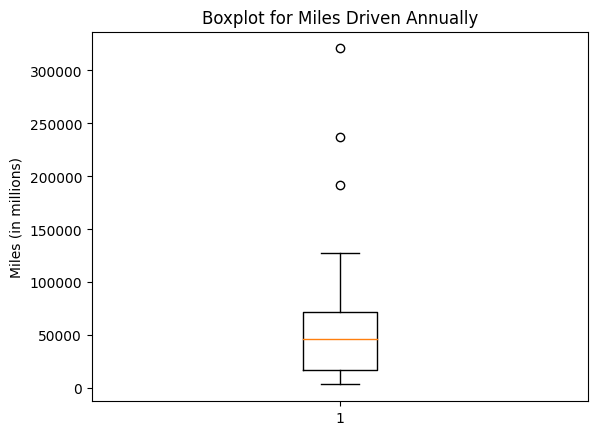

In [10]:
# Boxplot for miles driven dataset
plt.boxplot(combined_df['million_miles_annually'])
plt.title('Boxplot for Miles Driven Annually')
plt.ylabel('Miles (in millions)')
plt.show()

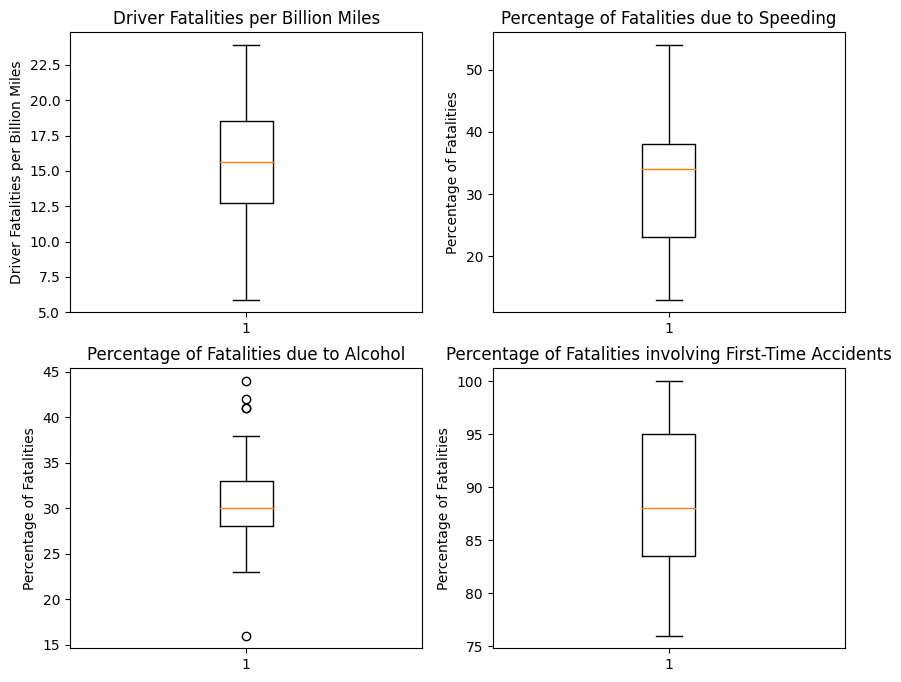

In [11]:
# Boxplot for road accidents dataset
fig, axs = plt.subplots(2, 2, figsize=(10,  8))

axs[0, 0].boxplot(combined_df['fatal_accidents_per_billion_miles'])
axs[0, 0].set_title('Driver Fatalities per Billion Miles')
axs[0, 0].set_ylabel('Driver Fatalities per Billion Miles')

axs[0, 1].boxplot(combined_df['percent_fatal_speeding'])
axs[0, 1].set_title('Percentage of Fatalities due to Speeding')
axs[0, 1].set_ylabel('Percentage of Fatalities')

axs[1, 0].boxplot(combined_df['percent_fatal_alcohol'])
axs[1, 0].set_title('Percentage of Fatalities due to Alcohol')
axs[1, 0].set_ylabel('Percentage of Fatalities')

axs[1, 1].boxplot(combined_df['percent_fatal_1st_time'])
axs[1, 1].set_title('Percentage of Fatalities involving First-Time Accidents')
axs[1, 1].set_ylabel('Percentage of Fatalities')

plt.show()

In the dataset, there are a few outliers in the fatal_accidents_per_billion_miles column, but they are not extreme and can be safely ignored for now.

## 3. Create a textual and a graphical summary of the data

In [12]:
# Compute summary statistics and pairwise scatter plot
print("Summary statistics of all columns:")
print(combined_df.describe())

Summary statistics of all columns:
       million_miles_annually  fatal_accidents_per_billion_miles  \
count               51.000000                          51.000000   
mean             57851.019608                          15.790196   
std              59898.414088                           4.122002   
min               3568.000000                           5.900000   
25%              17450.000000                          12.750000   
50%              46606.000000                          15.600000   
75%              71922.500000                          18.500000   
max             320784.000000                          23.900000   

       percent_fatal_speeding  percent_fatal_alcohol  percent_fatal_1st_time  
count               51.000000              51.000000                51.00000  
mean                31.725490              30.686275                88.72549  
std                  9.633438               5.132213                 6.96011  
min                 13.000000       

1. The mean of 'million_miles_annually' has increased from the previous dataset indicating a possible increase in overall driving distance.
2. The maximum value of 'million_miles_annually' has significantly increased from 191855 to 320784, indicating a possible presence of outliers.
3. The mean of 'percent_fatal_speeding' has also increased from the previous dataset, indicating a possible increase in speeding-related accidents.
4. The maximum value of 'percent_fatal_1st_time' has increased to 100%, indicating that in some states, all fatal accidents were caused by drivers driving for the first time.

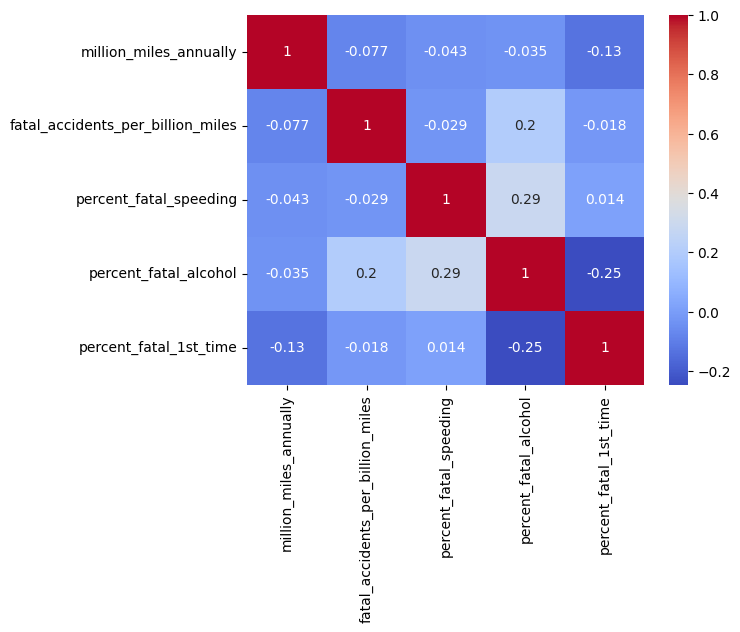

In [13]:
# Create a heatmap of feature correlations
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm')

# Show the plot
plt.show()

## 4. Quantify the association of features and accidents

To quantify the pairwise relationships that we observed in the scatter plots, we can compute the Pearson correlation coefficient matrix. The Pearson correlation coefficient is one of the most common methods to quantify correlation between variables, and by convention, the following thresholds are usually used:

0.2 = weak

0.5 = medium

0.8 = strong

0.9 = very strong

In [14]:
# Compute correlation coefficients and print correlation matrix
corr_columns = combined_df.corr()
print("Correlation matrix:")
print(corr_columns)

Correlation matrix:
                                   million_miles_annually  \
million_miles_annually                           1.000000   
fatal_accidents_per_billion_miles               -0.077133   
percent_fatal_speeding                          -0.043199   
percent_fatal_alcohol                           -0.034561   
percent_fatal_1st_time                          -0.128928   

                                   fatal_accidents_per_billion_miles  \
million_miles_annually                                     -0.077133   
fatal_accidents_per_billion_miles                           1.000000   
percent_fatal_speeding                                     -0.029080   
percent_fatal_alcohol                                       0.199426   
percent_fatal_1st_time                                     -0.017942   

                                   percent_fatal_speeding  \
million_miles_annually                          -0.043199   
fatal_accidents_per_billion_miles               -0.029080 

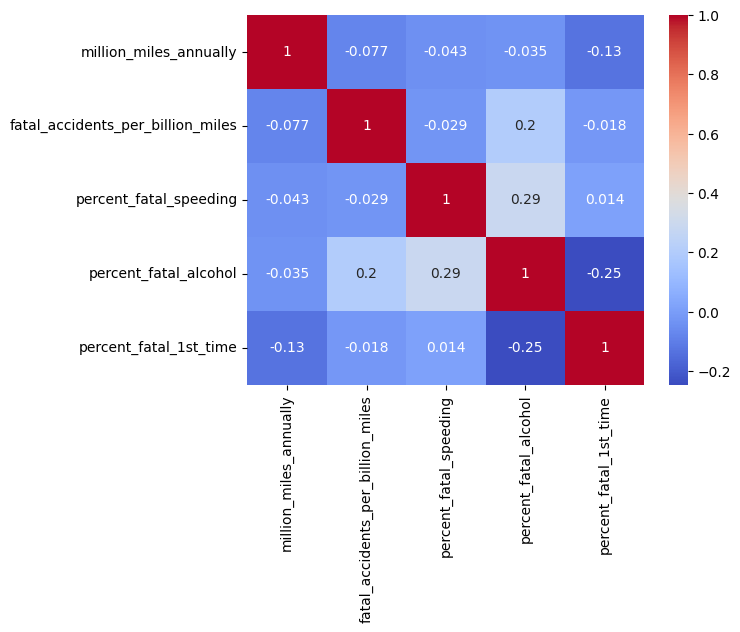

In [15]:
# Create a heatmap of feature correlations
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm')

# Show the plot
plt.show()

**Observations:**

1. There is a negative correlation between million miles driven annually and fatal accidents per billion miles, **which means as the number of miles driven annually increases, the rate of fatal accidents per billion miles decreases.**

2. There is a positive correlation between fatal accidents per billion miles and percent fatal alcohol, **indicating that as the percentage of fatal accidents involving alcohol increases, the rate of fatal accidents per billion miles also increases.**

3. There is a positive correlation between percent fatal speeding and percent fatal alcohol, **implying that drivers who are under the influence of alcohol are more likely to speed and cause fatal accidents.**

4. There is a negative correlation between percent fatal alcohol and percent fatal 1st time, **suggesting that drivers who cause fatal accidents while under the influence of alcohol are less likely to be first-time offenders.**

5. There is a negative correlation between million miles driven annually and percent fatal 1st time, **indicating that as the number of miles driven annually increases, the percentage of fatal accidents caused by first-time offenders decreases.**

## 5. Fit a multivariate linear regression

In [16]:
# Define the features and target variables to be used for the regression
features = combined_df[['percent_fatal_speeding', 'percent_fatal_alcohol', 'percent_fatal_1st_time']]
target = combined_df['fatal_accidents_per_billion_miles']

# Create a LinearRegression object and fit the data
reg = LinearRegression().fit(features, target)

# Retrieve the coefficients for the fitted regression
fit_coef = reg.coef_

# Create a table to show the coefficients
coef_table = pd.DataFrame({'Coefficient Name': features.columns, 'Coefficient Value': fit_coef})

# Print the coefficient table
print("Coefficient Table:\n", coef_table)

# Print the equation for the fitted regression
equation = "y = {:.3f}x1 + {:.3f}x2 + {:.3f}x3 + {:.3f}".format(fit_coef[0], fit_coef[1], fit_coef[2], reg.intercept_)
print("\nEquation:", equation)

Coefficient Table:
          Coefficient Name  Coefficient Value
0  percent_fatal_speeding          -0.041800
1   percent_fatal_alcohol           0.190864
2  percent_fatal_1st_time           0.024733

Equation: y = -0.042x1 + 0.191x2 + 0.025x3 + 9.065


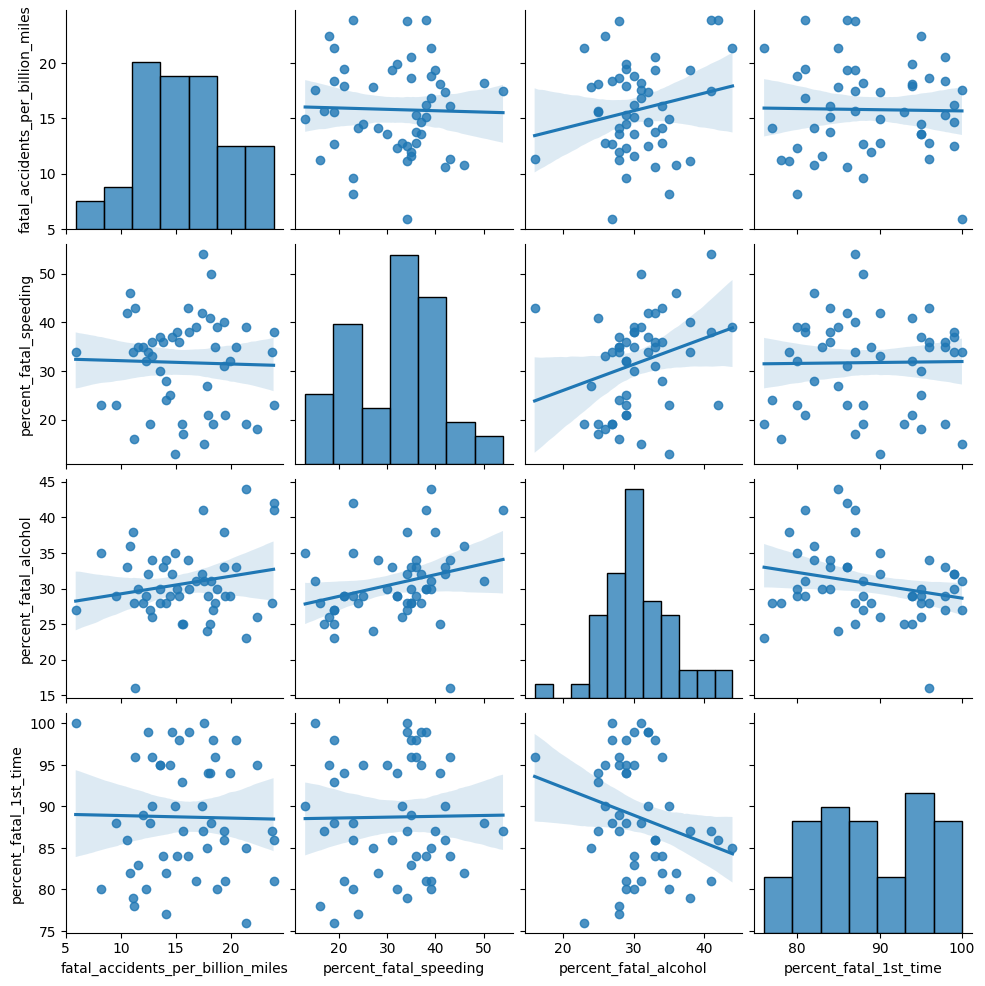

In [17]:
# Select only the numeric features
numeric_features = ['fatal_accidents_per_billion_miles', 'percent_fatal_speeding', 'percent_fatal_alcohol', 'percent_fatal_1st_time']

# Create a pair plot with linear regression lines
sns.pairplot(data=combined_df, vars=numeric_features, kind='reg')

In [18]:
# Calculate R^2, MSE, and RMSE
y_pred = reg.predict(features)
r2 = r2_score(target, y_pred)
mse = mean_squared_error(target, y_pred)
rmse = math.sqrt(mse)

# Create a table to show the R^2, MSE, and RMSE
metric_table = pd.DataFrame({'Metric': ['R^2 Score', 'Mean Squared Error', 'Root Mean Squared Error'], 'Value': [r2, mse, rmse]})

# Print the metric tables
print("\nMetric Table:\n", metric_table)


Metric Table:
                     Metric      Value
0                R^2 Score   0.049483
1       Mean Squared Error  15.833466
2  Root Mean Squared Error   3.979129


## 6. Perform PCA on standardized data

In [19]:
combined_df.columns

Index(['state', 'million_miles_annually', 'fatal_accidents_per_billion_miles',
       'percent_fatal_speeding', 'percent_fatal_alcohol',
       'percent_fatal_1st_time'],
      dtype='object')

In [20]:
combined_df['num_drvr_fatl_col'] = (combined_df['fatal_accidents_per_billion_miles'] / 1000) * combined_df['million_miles_annually']

In [21]:
combined_df.head()

,state,million_miles_annually,fatal_accidents_per_billion_miles,percent_fatal_speeding,percent_fatal_alcohol,percent_fatal_1st_time,num_drvr_fatl_col
0,Alabama,64914,18.8,39,30,80,1220.3832
1,Alaska,4593,18.1,41,25,94,83.1333
2,Arizona,59575,18.6,35,28,96,1108.0950
3,Arkansas,32953,22.4,18,26,95,738.1472
4,California,320784,12.0,35,28,89,3849.4080


In [22]:
# Select features for clustering and standardize them
features = ['percent_fatal_speeding', 'percent_fatal_alcohol', 'percent_fatal_1st_time']
# Standardize and center the feature columns
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_df[features])

<!-- # Fit the PCA to the standardized data
pca = PCA().fit(features_scaled)

# Plot the proportion of variance explained by each principal component
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')

# Set the x-axis tick marks to show only the first three principal components
plt.xticks([1, 2, 3])

# Compute the cumulative proportion of variance explained by the first two principal components
cumulative_var_exp = sum(pca.explained_variance_ratio_[:2])
print(f"The cumulative variance of the first two principal components is {cumulative_var_exp:.5f}") -->

When considering the first two principal components together, the variance explained is 0.79470


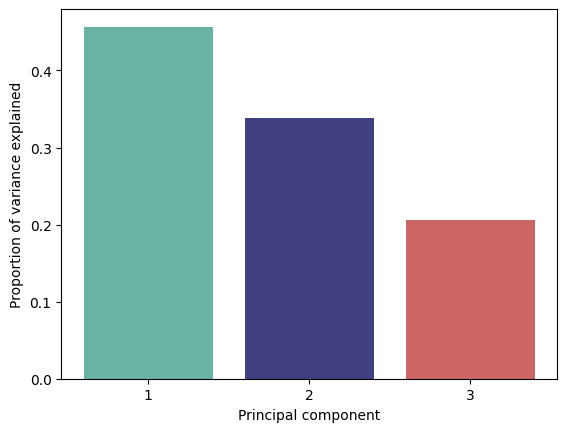

In [23]:
# Fit the PCA to the standardized data
pca = PCA().fit(features_scaled)

# Create a bar plot of the proportion of variance explained by each principal component
fig, ax = plt.subplots()
ax.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, color=['#69b3a2','#404080','#cc6666'])
ax.set_xlabel('Principal component')
ax.set_ylabel('Proportion of variance explained')

# Set the x-axis tick marks to show only the first three principal components
ax.set_xticks([1, 2, 3])

# Compute the cumulative proportion of variance explained by the first two principal components
cumulative_var_exp = sum(pca.explained_variance_ratio_[:2])
print(f"When considering the first two principal components together, the variance explained is {cumulative_var_exp:.5f}")

## 7. Visualize the first two principal components

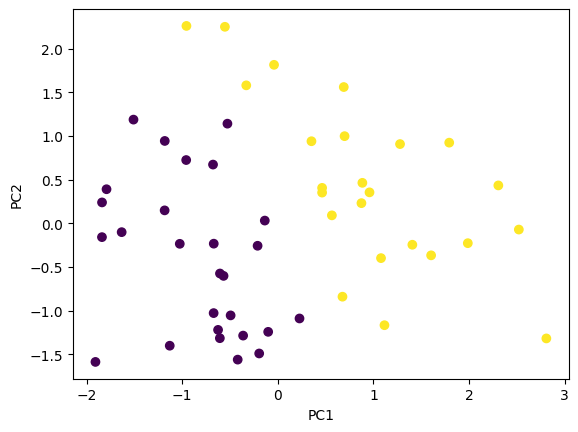

In [24]:
# Perform clustering with the optimal number of clusters (k=3) and visualize the results
kmeans = KMeans(n_clusters=2, random_state=8)
kmeans.fit(features_scaled)
combined_df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
p_comps = pca.fit_transform(features_scaled)
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=combined_df['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 8. Find clusters of similar states in the data

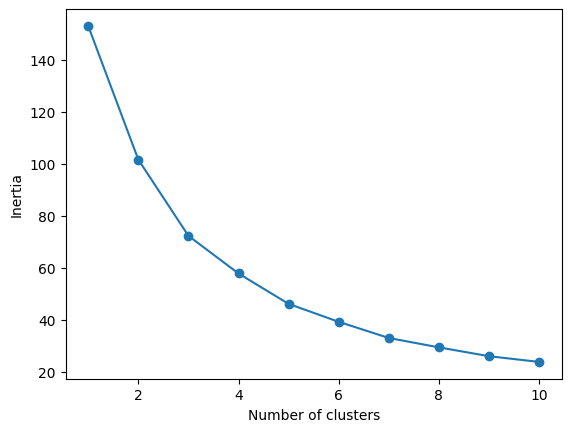

In [25]:
# Determine the optimal number of clusters using the elbow method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

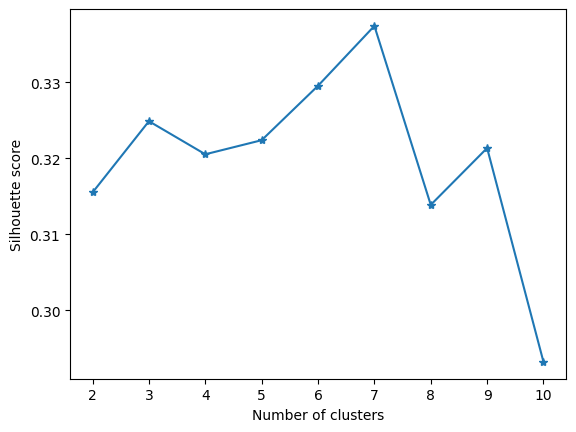

In [26]:
# Validate the quality of the clustering results using the silhouette score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(features_scaled)
    score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(2, 11), silhouette_scores, marker='*')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

## 9. KMeans to visualize clusters in the PCA scatter plot

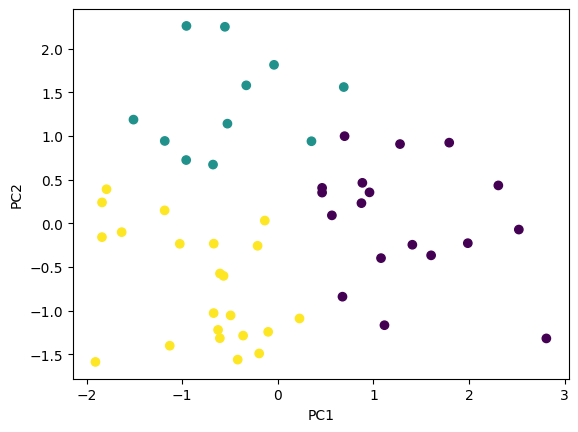

In [27]:
# Perform clustering with the optimal number of clusters (k=3) and visualize the results
kmeans = KMeans(n_clusters=3, random_state=8)
kmeans.fit(features_scaled)
combined_df['cluster'] = kmeans.labels_

pca = PCA(n_components=2)
p_comps = pca.fit_transform(features_scaled)
plt.scatter(p_comps[:, 0], p_comps[:, 1], c=combined_df['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## 10. Visualize the feature differences between the clusters

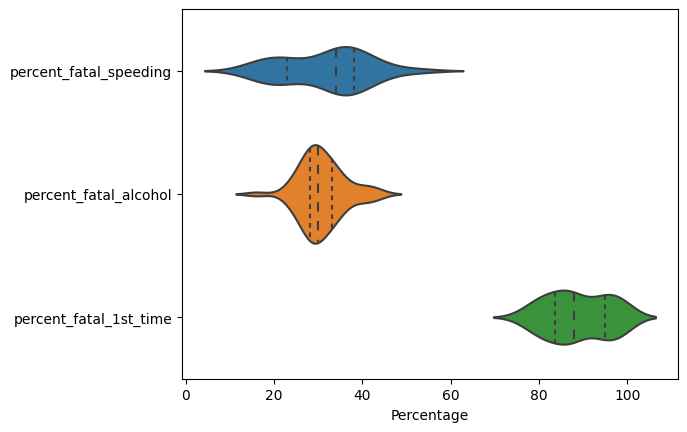

In [28]:
melt_car = pd.melt(combined_df, id_vars='cluster', value_vars=features, var_name='measurement', value_name='percent')
sns.violinplot(x='percent', y='measurement',  data=melt_car, split=True, inner='quart')
plt.xlabel('Percentage')
plt.ylabel('')
plt.show()

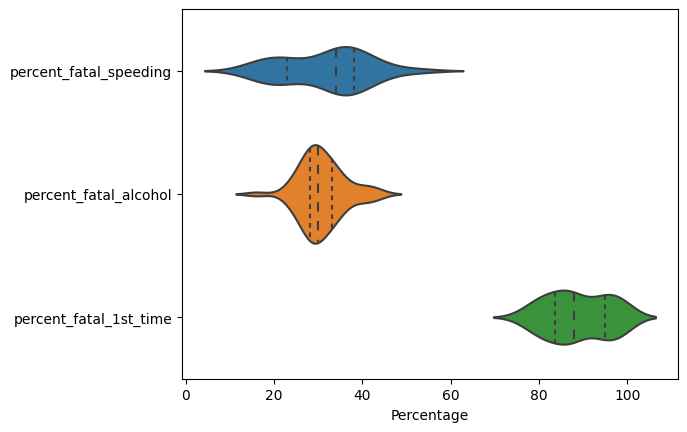

In [29]:
# Create a new column with the labels from the KMeans clustering
combined_df['cluster'] = kmeans.labels_

# Reshape the DataFrame to the long format
melt_car = pd.melt(combined_df, id_vars='cluster', value_vars=features, var_name='measurement', value_name='percent')

# Create a violin plot splitting and coloring the results according to the km-clusters
sns.violinplot(x='percent', y='measurement', data=melt_car, split=True, inner='quart')
plt.xlabel('Percentage')
plt.ylabel('')
plt.show()

## 11. Compute the number of accidents within each cluster

        num_drvr_fatl_col                        
                    count        mean         sum
cluster                                          
0                      18  911.406439  16405.3159
1                      11  860.505945   9465.5654
2                      22  898.378595  19764.3291


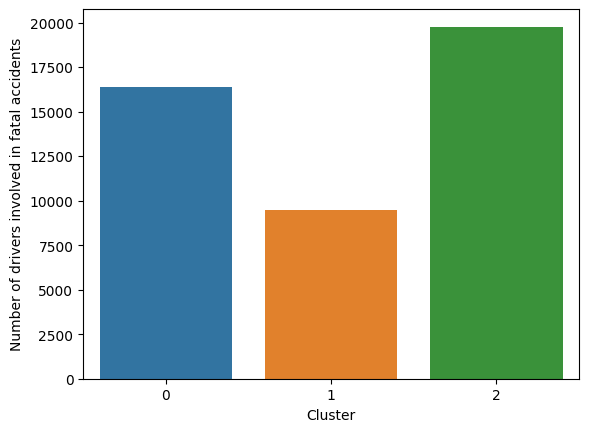

In [30]:
# Compute the number of accidents within each cluster
count_mean_sum = combined_df.groupby('cluster').agg({'num_drvr_fatl_col': ['count', 'mean', 'sum']})
print(count_mean_sum)
sns.barplot(x='cluster', y='num_drvr_fatl_col', data=combined_df, estimator=np.sum, errorbar=None)
plt.xlabel('Cluster')
plt.ylabel('Number of drivers involved in fatal accidents')
plt.show()

## 12. Make a decision when there is no clear right choice

If the goal is to reduce traffic mortality in the USA, the cluster that you should focus on would be the one with the highest number of fatal collisions per billion miles driven, since this cluster represents the riskiest drivers. In this case, that would be Cluster 0, which has the highest mean and sum of num_drvr_fatl_col.

Therefore, if you want to reduce traffic mortality in the USA, you could target interventions or educational programs towards drivers in Cluster 0. Possible interventions could include promoting safe driving behaviors, enforcing traffic laws, increasing awareness about the dangers of distracted or impaired driving, or providing additional training for new or inexperienced drivers. It may also be helpful to conduct further analysis to identify any specific patterns or characteristics that differentiate the drivers in Cluster 0, which could help tailor the interventions to their needs and preferences.